In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import Audio
from scipy.io import wavfile
import soundfile as sf
import tensorflow as tf
import tensorflow_hub as hub
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import scipy
import librosa
import pandas as pd
import os
from scipy.io import wavfile
from tqdm import tqdm
import random
from pydub import AudioSegment
import os
import os
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub


Custom Number of Samples

In [29]:
import pandas as pd
import os

# Define input folder containing the preprocessed audio files
input_folder = r'AudioSet\new_refined'

# Initialize lists to store data
file_paths = []
class_names = []

# Define the target number of files per category
target_files_per_category = 600

# Iterate over each file in the input folder
for file_name in os.listdir(input_folder):
    folder_path = os.path.join(input_folder, file_name)
    
    # Check if the item is a directory
    if os.path.isdir(folder_path):
        class_name = file_name  # Use folder name as class name
        
        # Collect all files in the directory
        files_in_class = [file for file in os.listdir(folder_path) if file.endswith(".wav")]
        
        # Determine how many files to select from this class
        selected_files = files_in_class[:target_files_per_category]  # Take only the first 300 files
        
        # Iterate over selected files
        for file in selected_files:
            file_path = os.path.join(folder_path, file)
            file_paths.append(file_path)
            class_names.append(class_name)

# Create DataFrame from the collected data
preprocessed_df = pd.DataFrame({
    'filename': file_paths,
    'category': class_names
})

# Display DataFrame
preprocessed_df


,filename,category
0,AudioSet\new_refined\Clicking\keyboard_typing_...,Clicking
1,AudioSet\new_refined\Clicking\keyboard_typing_...,Clicking
2,AudioSet\new_refined\Clicking\keyboard_typing_...,Clicking
3,AudioSet\new_refined\Clicking\keyboard_typing_...,Clicking
4,AudioSet\new_refined\Clicking\keyboard_typing_...,Clicking
...,...,...
2391,AudioSet\new_refined\Silence\silence_111_aug_c...,Silence
2392,AudioSet\new_refined\Silence\silence_111_aug_c...,Silence
2393,AudioSet\new_refined\Silence\silence_111_aug_c...,Silence
2394,AudioSet\new_refined\Silence\silence_111_aug_c...,Silence


Complete Samples

In [30]:
# # Define input folder containing the preprocessed audio files
# input_folder = r'AudioSet\new_refined'

# # Initialize lists to store data
# file_paths = []
# class_names = []

# # Iterate over each file in the input folder
# for file_name in os.listdir(input_folder):
#     folder_path = os.path.join(input_folder, file_name)
    
#     # Check if the item is a directory
#     if os.path.isdir(folder_path):
#         class_name = file_name  # Use folder name as class name
        
#         # Iterate over files in the directory
#         for file in os.listdir(folder_path):
#             if file.endswith(".wav"):
#                 file_path = os.path.join(folder_path, file)
                
#                 # Append file path and class name to lists
#                 file_paths.append(file_path)
#                 class_names.append(class_name)

# # Create DataFrame from the collected data
# preprocessed_df = pd.DataFrame({
#     'filename': file_paths,
#     'category': class_names
# })

# # Display DataFrame
# print(preprocessed_df)

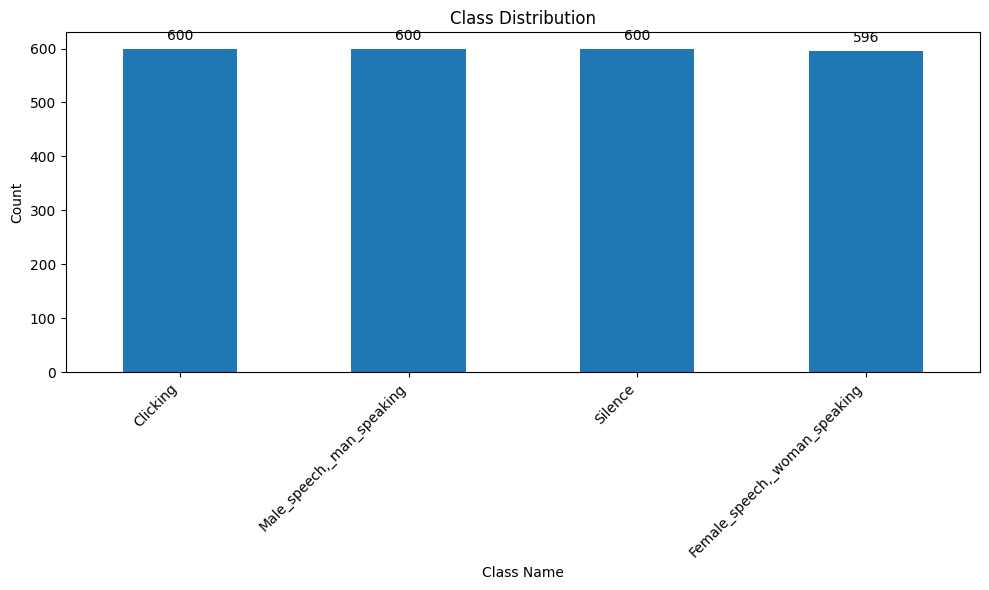

In [31]:
import matplotlib.pyplot as plt

# Group by class_name and count occurrences
class_distribution = preprocessed_df['category'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
ax = class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add count annotations to each bar
for i, count in enumerate(class_distribution):
    ax.text(i, count + 10, str(count), ha='center', va='bottom')

plt.show()

In [32]:
import pandas as pd
import numpy as np
import librosa

# Function to process audio files (ensure mono, 10 seconds length)
def process_audio(filename, sr=16000):
    # Load audio file in mono
    y, sr = librosa.load(filename, sr=sr, mono=True)
    
    return y, sr


In [33]:
import numpy as np
import librosa

def compute_mfcc(y, sr):
    # Check if audio length is greater than or equal to 10 seconds
    if len(y) >= sr * 1:
        # Clip the audio to 10 seconds
        y = y[:sr * 1]
    else:
        # If audio length is less than 10 seconds, zero-pad at the end
        zero_padding = np.zeros(sr * 1 - len(y), dtype=np.float32)
        y = np.concatenate([y, zero_padding])
        
    # Extract MFCC features for the entire audio
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    
    return mfccs.T  # Transpose the MFCC matrix to have time along the rows and features along the columns


In [34]:
from tqdm import tqdm
import pandas as pd

# List to store MFCCs and classes
mfcc_list = []
classes_list = []

# Process each file and compute MFCCs, using tqdm for progress
for index, row in tqdm(preprocessed_df.iterrows(), total=len(preprocessed_df), desc="Processing files"):
    filename = row['filename']
    category = row['category']
    
    # Process audio file to ensure it is 10 seconds long and mono
    y, sr = process_audio(filename)
    
    # Compute MFCC
    mfcc = compute_mfcc(y, sr)
    
    # Flatten the MFCC array and store it with its class
    mfcc_flat = mfcc.flatten()
    mfcc_list.append(mfcc_flat)
    classes_list.append(category)
    




Processing files: 100%|██████████| 2396/2396 [00:18<00:00, 129.44it/s]


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Convert lists to numpy arrays
mfcc_array = np.array(mfcc_list)
classes_array = np.array(classes_list)

# Shuffle the data
indices = np.arange(len(mfcc_array))
np.random.shuffle(indices)
mfcc_array = mfcc_array[indices]
classes_array = classes_array[indices]

# Perform one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
classes_onehot = encoder.fit_transform(classes_array.reshape(-1, 1))

# Get the mapping between class IDs and one-hot encoded labels
class_mapping = {idx: class_label for idx, class_label in enumerate(encoder.categories_[0])}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mfcc_array, classes_onehot, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

# Print the mapping between class IDs and one-hot encoded labels
print("Class ID Mapping:")
for idx, class_label in class_mapping.items():
    print(f"Class ID: {idx}, Class Label: {class_label}")


Training data shape: (1916, 1280)
Testing data shape: (480, 1280)
Training labels shape: (1916, 4)
Testing labels shape: (480, 4)
Class ID Mapping:
Class ID: 0, Class Label: Clicking
Class ID: 1, Class Label: Female_speech,_woman_speaking
Class ID: 2, Class Label: Male_speech,_man_speaking
Class ID: 3, Class Label: Silence


In [36]:
X_train = X_train.reshape(X_train.shape[0], 32, 40)
X_test = X_test.reshape(X_test.shape[0], 32, 40)

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import L2

# Initialize the 1D CNN model
CNN1D_Model = Sequential()

# Add 1D Convolutional layers
CNN1D_Model.add(Conv1D(64, 3, padding="same", activation="relu", input_shape=(32, 40)))
CNN1D_Model.add(MaxPooling1D(pool_size=2))
CNN1D_Model.add(Conv1D(64, 3, padding="same", activation="relu"))
CNN1D_Model.add(MaxPooling1D(pool_size=2))
CNN1D_Model.add(Conv1D(64, 3, padding="same", activation="relu"))

# Add Dropout layer and flatten the output
CNN1D_Model.add(Dropout(0.1))
CNN1D_Model.add(Flatten())

# Add Dense layers
CNN1D_Model.add(Dense(1024, activation="relu"))
CNN1D_Model.add(Dense(4, activation="softmax"))

# Print model summary
CNN1D_Model.summary()


# Compile the model
CNN1D_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
CNN1D_Model.summary()




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 32, 64)            7744      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 16, 64)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 16, 64)            12352     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 8, 64)            0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 8, 64)             12352     
                                                                 
 dropout_2 (Dropout)         (None, 8, 64)            

In [38]:
# Train the model
history = CNN1D_Model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.1)

Epoch 1/15
27/27 [==============================] - 1s 20ms/step - loss: 13.3840 - accuracy: 0.5174 - val_loss: 0.5801 - val_accuracy: 0.7656
Epoch 2/15
27/27 [==============================] - 0s 15ms/step - loss: 0.4856 - accuracy: 0.8225 - val_loss: 0.3015 - val_accuracy: 0.8802
Epoch 3/15
27/27 [==============================] - 0s 14ms/step - loss: 0.2535 - accuracy: 0.9031 - val_loss: 0.2598 - val_accuracy: 0.9323
Epoch 4/15
27/27 [==============================] - 0s 12ms/step - loss: 0.1949 - accuracy: 0.9316 - val_loss: 0.2016 - val_accuracy: 0.9427
Epoch 5/15
27/27 [==============================] - 0s 14ms/step - loss: 0.1540 - accuracy: 0.9449 - val_loss: 0.1536 - val_accuracy: 0.9427
Epoch 6/15
27/27 [==============================] - 0s 13ms/step - loss: 0.1158 - accuracy: 0.9646 - val_loss: 0.1981 - val_accuracy: 0.9427
Epoch 7/15
27/27 [==============================] - 0s 14ms/step - loss: 0.0830 - accuracy: 0.9739 - val_loss: 0.2212 - val_accuracy: 0.9219
Epoch 8/15
2

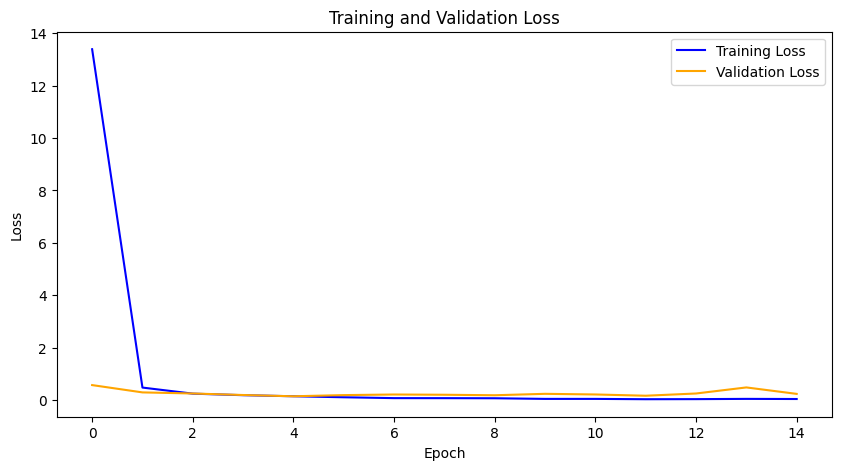

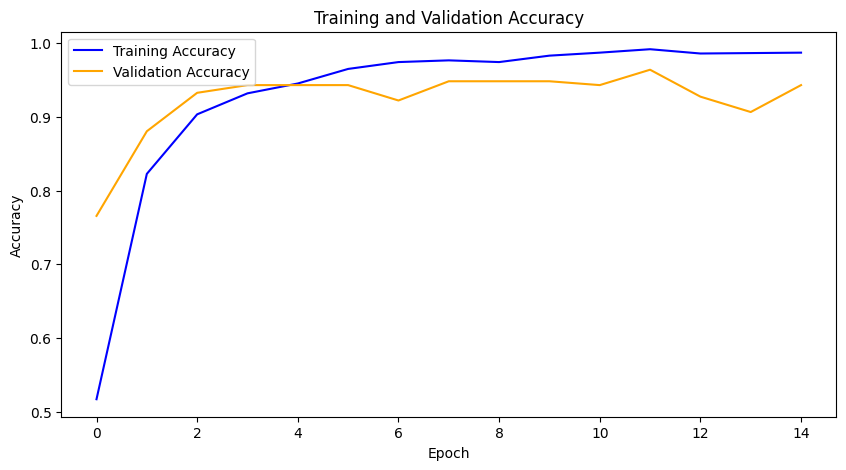

In [39]:
import matplotlib.pyplot as plt

# Extracting the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [40]:
# Evaluate the model on the test set
test_loss, test_accuracy = CNN1D_Model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict labels for the test set
y_pred = CNN1D_Model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

15/15 [==============================] - 0s 5ms/step - loss: 0.2675 - accuracy: 0.9146
Test Loss: 0.26751041412353516
Test Accuracy: 0.9145833253860474


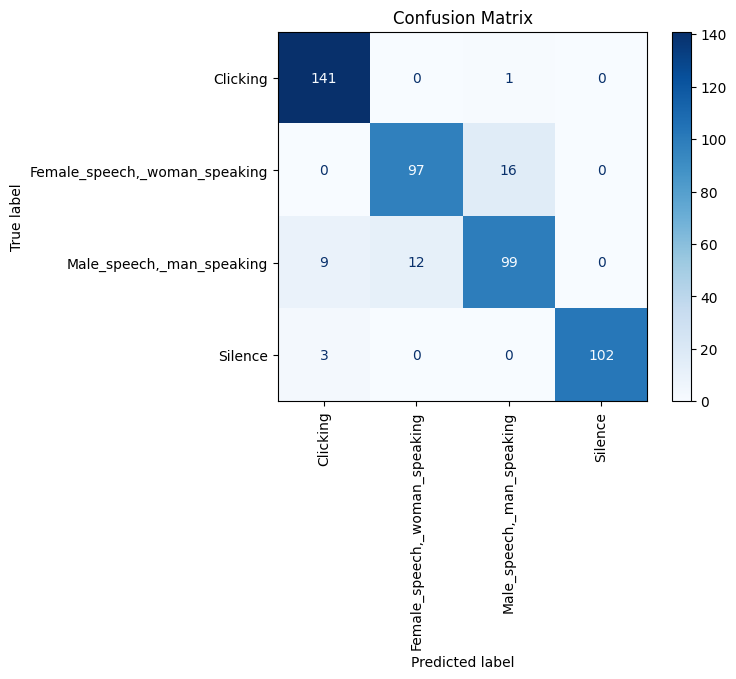

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Predict labels for the test set
y_pred = CNN1D_Model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot confusion matrix
labels = class_mapping.values()  # Assuming you have defined class_mapping
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)  # Rotate horizontal labels by 90 degrees
plt.show()

In [42]:
import tensorflow as tf

# Save the model to HDF5 file
CNN1D_Model.save("custom_CNN_model_4classes.h5")

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(CNN1D_Model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open("custom_CNN_model_4classes.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpimwnsrte\assets
